# Задание 1. A/B–тестирование

## Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# библиотеки для чтения данных
import requests as r
import json

%matplotlib inline

## Входные данные

В качестве входных данных имеется 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
    
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


## Считывание данных

In [87]:
# Функция для считывания данных с Яндекс Диска

def read_csv_file(link):
    file = r.get(f'https://cloud-api.yandex.net/v1/disk/public/resources?public_key={link}').json()['file']
     # при помощи параметра engine='python' в параметре sep удалось учесть несколько разделителей
    df = pd.read_csv(file, sep=';|,', engine='python')
    return df

In [88]:
# Ссылки на данные

groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [89]:
# Считывание данных

groups_df = read_csv_file(groups_link)
groups_add_df = read_csv_file(groups_add_link)
active_studs_df = read_csv_file(active_studs_link)
checks_df = read_csv_file(checks_link)

## Работа с исходными таблицами

In [90]:
# Проверка на корректность данных: в доп файле не дублируется id пользователя

groups_add_df.id.isin(groups_df.id).sum()

0

In [91]:
# Переименовал колонки

active_studs_df = active_studs_df.rename(columns={'"student_id"': 'id'})
checks_df = checks_df.rename(columns={'"student_id"': 'id', '"rev"': 'rev'})

In [92]:
# Совместил всех пользователей участвующих в A/B-тестировании 

all_users = pd.concat([groups_df, groups_add_df], ignore_index=True)

Применяю left join для таблицы с юзерами, которые зашли на платформу в дни проведения эксперемента с таблицой, содержащей всех пользователей, участвующих в A/B-тестировании.

Далее работаю с данной таблицей.

In [93]:
active_users = active_studs_df.merge(all_users, how='left', on='id')

In [94]:
# Джойн выполнен успешно

active_users.isnull().sum()

id     0
grp    0
dtype: int64

In [95]:
# Количество строк в таблице

active_users.shape[0]

8341

In [96]:
# Количество пользователей контрольной группы, которые зашли на платформу в дни проведения эксперимента

active_users_control = active_users[active_users.grp == 'A'].id.count()
active_users_control

1538

In [97]:
# Количество пользователей целевой группы, которые зашли на платформу в дни проведения эксперимента

active_users_target = active_users[active_users.grp == 'B'].id.count()
active_users_target

6803

Работа с таблицей checks_df

In [98]:
# Количество строк в таблице checks_df

checks_df.shape[0]

541

Количество уникальных значений id в таблице checks_df равно количеству строк.

Значит каждый пользователь, совершивший платное действие, произвел одну оплату в дни проведения тестирования.

In [99]:
# Количество уникальных значений id в таблице checks_df

checks_df.id.nunique()

541

In [100]:
# Джойн таблицы с оплатами пользователей с таблицей, содержащей активных пользователей во время тестирования

purchasing_users = checks_df.merge(active_users, how='inner', on='id')

149 пользователей, совершивших оплаты в дни проведения тестирования, не участвовали в эксперименте.

In [101]:
checks_df.shape[0] - purchasing_users.shape[0]

149

Далее работаем с 392 пользователями, совершивших оплату и участвующих в тестировании.

In [102]:
# Количество пользователей контрольной группы, которые совершили оплату в дни проведения эксперимента

purchasing_users_control = purchasing_users[purchasing_users.grp == 'A'].id.count()
purchasing_users_control

78

In [103]:
# Количество пользователей целевой группы, которые совершили оплату в дни проведения эксперимента

purchasing_users_target = purchasing_users[purchasing_users.grp == 'B'].id.count()
purchasing_users_target

314

## Проведение A/B-тестирования

### Тест №1

Для первого теста я буду использовать критерий хи-квадрат, в котором буду сравнивать количество активных пользователей и количество пользователей, совершивших оплату в дни проведения эксперимента по контрольной и целевой группам.



Из графика ниже можно увидеть, что соотношение пользователей разных групп примерно одинаково для таблиц с активными пользователями и пользователями, совершившими оплату. Следовательно, новая механика оплаты не показала своей эффективности.

Text(0.5, 1.0, 'purchasing_users')

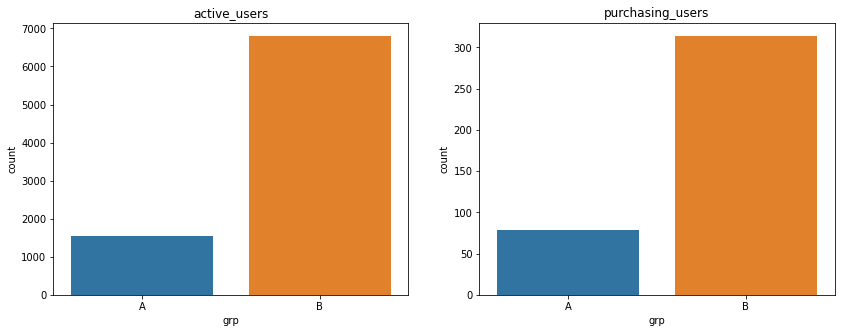

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.countplot(data=active_users, x='grp', ax=axes[0])
axes[0].set_title('active_users')

sns.countplot(data=purchasing_users, x='grp', ax=axes[1])
axes[1].set_title('purchasing_users')

Чтобы убедиться в стастической значимости утверждения выше, я применяю критерий хи-квадрат. Для этого создаем датафрейм 2х2 с активными и совершившими оплату пользователями, разделенными по группам.

In [105]:
active_purchasing_dictionary = {'active_users': [active_users_control, active_users_target], 'purchasing_users': [purchasing_users_control, purchasing_users_target]}

In [106]:
# Где под индексом 0 - контрольная группа, под индексом 1 - целевая

active_purchasing_crosstab = pd.DataFrame(active_purchasing_dictionary)
active_purchasing_crosstab

,active_users,purchasing_users
0,1538,78
1,6803,314


In [107]:
# Применяю критерий хи-квадрат

ss.chi2_contingency(active_purchasing_crosstab)

(0.43612258061018483,
 0.5089998823014525,
 1,
 array([[1543.46226955,   72.53773045],
        [6797.53773045,  319.46226955]]))

p-value равно 0.5. Следовательно, можно утверждать, что различия между группами в данном конктексте тестирования не являются статистически значимыми.

### Тест №2

В качестве второго теста я также применю критерий хи-квадрат. Но в этом случае в качестве таблицы сопряженности я буду использовать значения дохода от пользоваталей для двух групп и количество пользователей разных групп, совершивших оплату в дни проведения эксперимента.

График revenue_by_users отображает соотношение дохода от пользователей разных групп в дни проведения тестирования, а purchasing_users - соотношение пользователей, совершивших оплату.

Text(0.5, 1.0, 'purchasing_users')

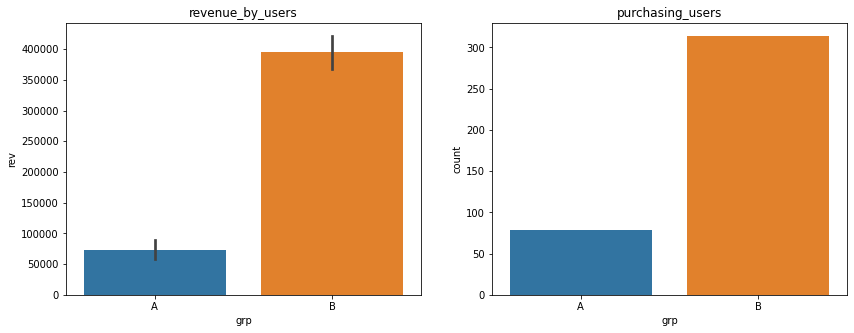

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.barplot(data=purchasing_users, x='grp', y='rev', estimator=sum, ax=axes[0])
axes[0].set_title('revenue_by_users')

sns.countplot(data=purchasing_users, x='grp', ax=axes[1])
axes[1].set_title('purchasing_users')

In [109]:
# Доход от пользователей контрольной группы в дни проведения эксперимента

revenue_control = purchasing_users[purchasing_users.grp == 'A'].rev.sum()
revenue_control

72820.0

In [110]:
# Доход от пользователей целевой группы в дни проведения эксперимента

revenue_target = purchasing_users[purchasing_users.grp == 'B'].rev.sum()
revenue_target

394974.0035

In [111]:
revenue_purchasing_dictionary = {'revenue': [revenue_control, revenue_target], 'purchasing_users': [purchasing_users_control, purchasing_users_target]}

In [112]:
# Где под индексом 0 - контрольная группа, под индексом 1 - целевая

revenue_purchasing_crosstab = pd.DataFrame(revenue_purchasing_dictionary)
revenue_purchasing_crosstab

,revenue,purchasing_users
0,72820.0000,78
1,394974.0035,314


In [113]:
# Применяю критерий хи-квадрат

ss.chi2_contingency(revenue_purchasing_crosstab)

(5.264739226632401,
 0.021761682832048646,
 1,
 array([[7.28369644e+04, 6.10356051e+01],
        [3.94957039e+05, 3.30964395e+02]]))

В данном тесте значение p-value меньше 0.05, что дает основание отклонить нулевую гипотезу, и полагать, что различия между группами статистически значимы.

### Тест №3

Для оценки новой механики оплаты, в качестве третьего теста я использую распределения дохода от пользователей контрольной и целевой группы.

In [114]:
# Пандас серия дохода от пользователей контрольной группы в дни проведения эксперимента

rev_control_series = purchasing_users[purchasing_users.grp == 'A'].rev

In [115]:
# Пандас серия дохода от пользователей целевой группы в дни проведения эксперимента

rev_target_series = purchasing_users[purchasing_users.grp == 'B'].rev

Провожу проверки на нормальность распределений дохода от пользователей разных групп.

In [116]:
ss.normaltest(rev_control_series)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [117]:
ss.normaltest(rev_target_series)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Распределения не прошли проверку на нормальность, но для достоверности результата я проведу и параметрический t-test и непараметрический тест Манна-Уитни.

In [118]:
# Применяю t-test

ss.ttest_ind(rev_control_series, rev_target_series)

Ttest_indResult(statistic=-3.1337795050930985, pvalue=0.0018562025265765867)

In [119]:
# Применяю критерий Манна-Уитни

ss.mannwhitneyu(rev_control_series, rev_target_series)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

В обоих случаях значение p-value сильно меньше 0.05, что говорит о статистической значимости различий значений между двумя выборками.

## Вывод

Было проведено 3 статистических теста, 2 из которых показали статистическую значимость. Новая механика оплаты услуг на сайте оказалась более эффективной по сравнению с базовой механикой. Отсюда следует вывод, что новую механику оплаты услуг стоит внедрить для всех пользователей сайта. 